In [18]:
import sys
import os
import glob
import cv2 as cv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
from torchviz import make_dot, make_dot_from_trace
%matplotlib inline


In [27]:
# Returns a training set loader
def train_set(batch_size_train):
    train_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), batch_size=batch_size_train, shuffle=True)
    return train_loader

#Returns a test set loader        
def test_set(batch_size_test):
    test_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])),batch_size=batch_size_test, shuffle=True)

    return test_loader

#function that loads previous trained model on to new models for task 2
#function also prints out model functions for the forward passs
def load_models(model1,model2):
    print("Loading Models")
    model1.load_state_dict(torch.load("model.pth.tar"))
    model2.load_state_dict(torch.load("model.pth.tar"))

    optimizer1 = optim.SGD(model1.parameters(), lr=0.01,
                      momentum=0.5)
    optimizer2 = optim.SGD(model2.parameters(), lr=0.01,
                      momentum=0.5)
    optimizer1.load_state_dict(torch.load("optimizer.pth.tar"))
    optimizer2.load_state_dict(torch.load("optimizer.pth.tar"))

    print(model1)
    for param_tensor in model1.state_dict():
        print(param_tensor, "\t", model1.state_dict()[param_tensor].size())
        
#Function that vizualizes the ten filters from the weight 1 of model
def show_filters(model):
    w1 = model.conv1.weight.data.numpy()
    plt.figure()
    for i in range (10):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        plt.imshow(w1[i,0])
        plt.title("Filter: {}".format(i))
        plt.xticks([])
        plt.yticks([])

#Function that convolves the filters on the image in grayscale and outputs the filters and the effect on the image
def effect_ofFilters(model,example_data):
    model.eval()
    with torch.no_grad():
        output = model(example_data)
    w1 = model.conv1.weight.data.numpy()
    img1 = example_data[0][0]
    img1 = np.array(img1)
    plt.figure(1)
    for i in range (10):
        filtered_imgs = cv.filter2D(img1,-1,w1[i,0])
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        plt.imshow(filtered_imgs, cmap='gray',interpolation='none')
        plt.xticks([])
        plt.yticks([])

    plt.figure(2)
    for i in range (10):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        plt.imshow(w1[i,0], cmap='gray',interpolation='none')
        plt.xticks([])
        plt.yticks([])
        
# Evaluates the 4x4 output of a truncated model at which the forward pass stops at the 2nd convolutional layer
def trunc_model(model2,example_data):
    model2.eval()
    with torch.no_grad():
        output = model2(example_data)
    out = output[1]
    out = np.array(out)
    size = out.shape
    print("Output size of truncated Model:", size)
    plt.figure(1)
    for i in range (12):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        plt.imshow(output[0][i], cmap='gray',interpolation='none')
        plt.title("Channel : {}".format(i))
        plt.xticks([])
        plt.yticks([])

In [28]:
class MyNet(nn.Module):
    #two conv filter(5x5 kerenels), dropout 50%, two linear layers, and a flatten layer
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.flatten = nn.Flatten()
        self.fc2 = nn.Linear(50, 10)
        
    #feeds input in defined layers ad applies operations to the layer output
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(F.dropout(self.conv2(x)), 2),0.5)
        x = x.view(-1, 320)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x)
    
#Truncated model of above network, in which forward pass stops at second convolutional layer
class Submodel_MyNet(nn.Module):
    def __init__(self):
        super(Submodel_MyNet,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.flatten = nn.Flatten()
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(F.dropout(self.conv2(x)), 2),0.5)
        return x


In [33]:
#Main function that executes all the functions to present all of Task 2
def main():
    n_epochs = 3
    batch_train = 64
    batch_test = 1000

    torch.backends.cudnn.enabled = False
    torch.manual_seed(42)
    
    test_loader = test_set(batch_test)
    train_loader = train_set(batch_train)
    
    examples = enumerate(test_loader)
    batch_idx, (example_data,example_targets)=next(examples)

    model1 = MyNet()
    model2 = Submodel_MyNet()
        
    #task2A: visualize ten filters
    print("task2A")
    show_filters(model1)
    
    #Task 2B: show effects of filters
    print("Task2B")
    effect_ofFilters(model1,example_data)
    
    #Task 2C: second layet output of truncated model
    print("Task2C")
    trunc_model(model2,example_data)

task2A
Task2B


<ipython-input-28-d6fbcefe0f75>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
<ipython-input-27-7838890a1755>:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,4,i+1)


Task2C
Output size of truncated Model: (20, 4, 4)


<ipython-input-27-7838890a1755>:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,4,i+1)


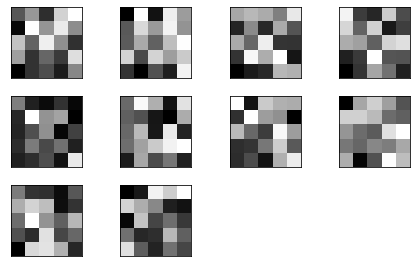

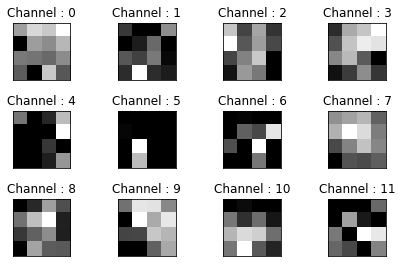

In [34]:
if __name__== "__main__":
    main()